# Kwenta Quantity Adjusting "Quanto" Perpetual Futures

A quanto perpetual futures contract is a derivative where the underlying is denominated in one asset, such as `$ETH`, but the derivative is settled in another, such as `$BTC`.


🚨 Points of Concern

1. **Covariance** - Suggests increased risk for traders. In traditional finance (TradFi), this is often managed through "exorbitant" funding rates

2. **Funding Rate** - In non-quanto perpetuals, the funding rate depends on market skew and base asset price. For quanto perpetuals, consider the impact of the quanto asset. There are notable differences in funding rates between platforms like BitMEX and Synthetix; exploring the reasons for these differences is crucial.

3. **Risk for Liquidity Providers (LPs)** - The risk is higher for LPs if the collateral is not in the quanto asset, or if proper hedging strategies are not implemented. For example, consider the significant losses experienced by Synthetix (`$SNX`) stakers during a surge in a long-tail asset. In a quanto market scenario where `$ETH` also surges, the dynamics and potential risks would be different and worth examining.

4. **Hedging** - From [here](https://mathfinance.com/wp-content/uploads/2017/06/wystup_quanto_eqf.pdf), hedging correlation risk can only be done via "other derivatives depending on the same correlation" and is "normally not possible." [Vega Positions of Quanto Plain Vanilla Options](https://mathfinance.com/wp-content/uploads/2017/06/wystup_quanto_eqf.pdf) this is an example of hedging vanilla quanto options that might serve as a guide to hedge our own instruments


In [737]:
from variables import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

## Parameters


### Market and Position Parameters


#### Position Size

-   Long positions are positive, short positions are negative
-   Measured in units of the base (`$BASE`) *and* quanto (`$QUANTO`) asset
    -   initial_margin: `$QUANTO`
    -   initial_leverage: N/A
    -   initial_base_asset_spot_price: `$USD/$BASE`

💡 thus, in terms of units:

```
($QUANTO * λ) / ($USD / $BASE) = ($QUANTO * λ) * ($BASE / $USD) = $QUANTO * $BASE / $USD
```

> λ (i.e. leverage) has no units, so it can be removed when determining the units of the position size.


In [738]:
position_size = (initial_margin * initial_leverage) / initial_base_asset_spot_price


def calculate_position_size(
    initial_margin, initial_leverage, initial_base_asset_spot_price
):
    return (initial_margin * initial_leverage) / initial_base_asset_spot_price

#### Notional Value

-   long positions are positive, short positions are negative
-   Measured in units of the quanto (`$QUANTO`) asset
    -   position_size: `$QUANTO * $BASE / $USD`
    -   base_asset_spot_price: `$USD/$BASE`

💡 thus, in terms of units:

```
($QUANTO * $BASE / $USD) * ($USD / $BASE) = $QUANTO
```


Current Notional Value


In [739]:
notional_value = position_size * base_asset_spot_price


def calculate_notional_value(position_size, base_asset_spot_price):
    return position_size * base_asset_spot_price

Initial Notional Value


In [740]:
initial_notional_value = initial_margin * initial_leverage


def calculate_initial_notional_value(initial_margin, initial_leverage):
    return initial_margin * initial_leverage

#### Profit and Loss (PnL)

-   The profit in a position is the change in its notional value since entry
-   Measured in units of the quanto (`$QUANTO`) asset


In [741]:
profit_and_loss = notional_value - initial_notional_value


def calculate_profit_and_loss(notional_value, initial_notional_value):
    return notional_value - initial_notional_value

#### Market Size

-   Total size of all outstanding positions in the market


In [742]:
market_size = (
    sum(set_of_all_positions_in_the_market)
    if sum(set_of_all_positions_in_the_market)
    == set_of_all_long_positions_in_the_market
    + set_of_all_short_positions_in_the_market
    else Exception("Market size calculation error")
)


def calculate_market_size(
    set_of_all_positions_in_the_market,
    set_of_all_long_positions_in_the_market,
    set_of_all_short_positions_in_the_market,
):
    total_market_size = sum(set_of_all_positions_in_the_market)
    if (
        total_market_size
        == set_of_all_long_positions_in_the_market
        + set_of_all_short_positions_in_the_market
    ):
        return total_market_size
    else:
        raise Exception("Market size calculation error")

#### Market skew

-   Ratio of long to short positions in the market (relative to position_size)
-   Positive skew means more longs than shorts
-   Negative skew means more shorts than longs


In [743]:
market_skew = sum(position.size for position in set_of_all_positions_in_the_market)


def calculate_market_skew(set_of_all_positions_in_the_market):
    return sum(position.size for position in set_of_all_positions_in_the_market)

### Leverage and Margins Parameters


#### Leverage

-   The ratio of notional value to margin
-   λ = v / m
-   Is unitless because both v and m are measured in units of the quanto (`$QUANTO`) asset and thus cancel out


Current Leverage


In [744]:
leverage = notional_value / remaining_margin


def calculate_leverage(notional_value, remaining_margin):
    return notional_value / remaining_margin

Initial Leverage


In [745]:
initial_leverage = initial_notional_value / initial_margin


def calculate_initial_leverage(initial_notional_value, initial_margin):
    return initial_notional_value / initial_margin

#### Margin


-   Measured in units of the quanto (`$QUANTO`) asset (signficant difference from non-quanto perpetuals where margin is measured in `$USD`)

```
($QUANTO * $BASE / $USD) * ($USD / $BASE) / λ = $QUANTO
```

> λ (i.e. leverage) has no units, so it can be removed when determining the units of the position size.


Initial Margin


In [746]:
initial_margin = position_size * initial_base_asset_spot_price / initial_leverage


def calculate_initial_margin(
    position_size, initial_base_asset_spot_price, initial_leverage
):
    return (position_size * initial_base_asset_spot_price) / initial_leverage

Remaining Margin

-   if `remaining_margin < 0`, position is liquidated


In [747]:
remaining_margin = max(initial_margin + profit_and_loss + accrued_position_funding, 0)


def calculate_remaining_margin(
    initial_margin, profit_and_loss, accrued_position_funding
):
    return max(initial_margin + profit_and_loss + accrued_position_funding, 0)

Position Debt

-   Margin "owed" to the "system" (i.e. margin that must be paid back to close the position)
    -   When a position is closed, the funds in its margin are settled. After profit and funding are computed, the remaining margin will be minted into the account that created the position, while any losses out of the initial margin, will be minted into the fee pool."
-   As established above, **notional value is measured in units of the quanto asset**.
-   As established above, **margin is also measured in units of the quanto asset**.
-   Thus, position debt is measured in units of the quanto asset.

🙋‍♂️ The Synthetix v3 core measures/calculates position debt in `$USD`. Thus, conversion between `$USD` and `$QUANTO` is required.


In [748]:
position_debt = abs(initial_notional_value) - initial_margin


def calculate_position_debt(initial_notional_value, initial_margin):
    return abs(initial_notional_value) - initial_margin

### Exchange Fees

-   Fees are imposed when a position is (1) opened, (2) increased


#### Maker

-   A maker is a trader who is reducing skew in the market.
    -   If the market is long skew, a maker is a trader who is opening a short position. If the market is short skew, a maker is a trader who is opening a long position.


#### Taker

-   A taker is a trader who is increasing skew in the market.
    -   If the market is long skew, a taker is a trader who is opening a long position. If the market is short skew, a taker is a trader who is opening a short position.


#### Fees

-   fees will be charged out of the user's remaining margin
    -   since fees are charged out of the remaining margin, they will affect the user's leverage


### Skew Funding Rate


-   Term: Market Skew
    -   Market Skew refers to the difference in open interest between long and short positions in the market
    -   A positive Market Skew indicates that the total open interest in long positions exceeds that in short positions
        -   suggests a market inclination towards rising prices
    -   A negative Market Skew suggests that the total open interest in short positions surpasses that in long positions
        -   suggests a market tendency towards falling prices
-   Term: Funding Rate
    -   The funding rate has the opposite sign to the skew, as funding flows "against capital in the market"
    -   When the funding rate is positive, shorts pay longs
    -   When the funding rate it is negative, longs pay shorts


#### Proportional Skew

-   The skew normalized by the skew scaling constant.


In [749]:
proportional_skew = market_skew / skew_scaling_denominator_constant


def calculate_proportional_skew(market_skew, skew_scaling_denominator_constant):
    return market_skew / skew_scaling_denominator_constant

### Instantaneous Funding Rate


-   Funding accumulates continuously; changes in **market skew** or **base asset price** affect funding for all open positions
-   Frequent updates between opening and closing positions are costly
-   Total accrued funding per base currency unit is recorded whenever the skew changes; individual position funding is calculated from this
-   Funding calculations use the spot rates at the time of skew changes, even though the base asset price may vary in between
-   If the market is active, any funding inaccuracies due to this method are typically minor


The Funding Rate is represented numerically as a percentage

-   The funding rate is paid/received per position based on **Position Size**


In [750]:
instantaneous_funding_rate = (
    np.clip((-proportional_skew / max_funding_skew_threshold), -1, 1) * max_funding_rate
)


def calculate_instantaneous_funding_rate(
    proportional_skew, max_funding_skew_threshold, max_funding_rate
):
    return (
        np.clip((-proportional_skew / max_funding_skew_threshold), -1, 1)
        * max_funding_rate
    )

### Aggregate Debt Calculation


#### Total Debt

-   The overall market debt is the sum of the remaining margin in all positions
-   The total debt is measured in units of the quanto (`$QUANTO`) asset


Aggregate Position Entry Debt Correction


In [751]:
aggregate_position_entry_debt_correction = (
    market_skew * (base_asset_spot_price + unrecorded_cumulative_funding)
) + np.sum(
    [
        (
            position.initial_margin
            - position.initial_notional_value
            - (
                position.position_size
                * position.unrecorded_cumulative_funding_at_last_modified_index
            )
        )
        for position in set_of_all_positions_in_the_market
    ]
)


def calculate_aggregate_position_entry_debt_correction(
    set_of_all_positions_in_the_market,
    market_skew,
    base_asset_spot_price,
    unrecorded_cumulative_funding,
):
    return (
        market_skew * (base_asset_spot_price + unrecorded_cumulative_funding)
    ) + np.sum(
        [
            (
                position.initial_margin
                - position.initial_notional_value
                - (
                    position.position_size
                    * position.unrecorded_cumulative_funding_at_last_modified_index
                )
            )
            for position in set_of_all_positions_in_the_market
        ]
    )

Market Debt


In [752]:
market_debt = max(
    market_skew * (base_asset_spot_price + unrecorded_cumulative_funding)
    + aggregate_position_entry_debt_correction,
    0,
)


def calculate_market_debt(
    market_skew,
    base_asset_spot_price,
    unrecorded_cumulative_funding,
    aggregate_position_entry_debt_correction,
):
    return max(
        market_skew * (base_asset_spot_price + unrecorded_cumulative_funding)
        + aggregate_position_entry_debt_correction,
        0,
    )

### Liquidations and Keepers


#### Liquidation margin

-   Liquidation margin below which a position will be liquidatable
-   It is a function of current spot price


In [753]:
liquidation_margin = max(
    position_size * base_asset_spot_price * liquidation_fee_ratio,
    minimal_keeper_incentive,
) + (position_size * base_asset_spot_price * liquidation_buffer_ratio)


def calculate_liquidation_margin(
    position_size,
    base_asset_spot_price,
    liquidation_fee_ratio,
    minimal_keeper_incentive,
    liquidation_buffer_ratio,
):
    return np.maximum(
        position_size * base_asset_spot_price * liquidation_fee_ratio,
        minimal_keeper_incentive,
    ) + (position_size * base_asset_spot_price * liquidation_buffer_ratio)

Minimal keeper incentive

-   The minimum incentive for a keeper to liquidate a position (in futures v1 this value was set to 20 `$sUSD`)


Liquidation buffer ratio

-   Ratio of notional position size that will be used as buffer to reduce chance of negative margin on large price updates


Liquidation fee ratio

-   Ratio of notional position size that will be paid to incentive liquidation keepers


Approxime liquidation price

-   Approximate liquidation price as estimated using liquidation margin calculated for current price
-   Will be above actual liquidation price for longs, and below for shorts


In [754]:
approximate_liquidation_price = (
    initial_base_asset_spot_price
    - ((initial_margin - liquidation_margin) / position_size)
    - (
        unrecorded_cumulative_funding
        - unrecorded_cumulative_funding_at_last_modified_index
    )
)


def calculate_approximate_liquidation_price(
    initial_base_asset_spot_price,
    initial_margin,
    liquidation_margin,
    position_size,
    unrecorded_cumulative_funding,
    unrecorded_cumulative_funding_at_last_modified_index,
):
    return (
        initial_base_asset_spot_price
        - ((initial_margin - liquidation_margin) / position_size)
        - (
            unrecorded_cumulative_funding
            - unrecorded_cumulative_funding_at_last_modified_index
        )
    )

## Payoffs


### Basic Payoff Analysis


Entry Margin

-   Units: `$QUANTO`


In [755]:
m_e = 100

Margin Exchange Rate (Set at Entry)

-   Units: `$USD/$QUANTO`


In [756]:
exchange_rate = 50

Entry Leverage

-   Units: N/A


In [757]:
λ_e = 1

Entry Spot Price of Base Asset

-   Units: `$USD/$BASE`


In [758]:
b_e = 50

Change in Spot Price of Base Asset (since entry)

-   Units: `$USD/$BASE`


In [759]:
Δbase = np.linspace(1, 100, 100)

Change in Spot Price of Quanto Asset (since entry)

-   Units: `$USD/$QUANTO`


In [760]:
Δquanto = np.linspace(1, 100, 100)

Payoff (as a function of spot price*s*)

-   Units: `$USD`
-   🧠 Intuition:
    -   if your payoff is 1 `$QUANTO`, and your fixed exchange rate is 1000 `$USD/$QUANTO`, and the spot price of the quanto asset is 1000 `$USD/$QUANTO`, then your pnl is 1000 `$USD`
    -   if your payoff is 1 `$QUANTO`, and your fixed exchange rate is 1000 `$USD/$QUANTO`, and the spot price of the quanto asset is 2000 `$USD/$QUANTO`, then your pnl is 2000 `$USD`
    -   if your payoff is 1 `$QUANTO`, and your fixed exchange rate is 1000 `$USD/$QUANTO`, and the spot price of the quanto asset is 500 `$USD/$QUANTO`, then your pnl is 500 `$USD`


In [761]:
payoff = calculate_profit_and_loss(
    calculate_notional_value(
        calculate_position_size(
            m_e,
            λ_e,
            b_e,
        ),
        Δbase,
    ),
    calculate_initial_notional_value(m_e, λ_e),
) * (exchange_rate - Δquanto)

Plot of Payoff (as a function of spot price*s*)


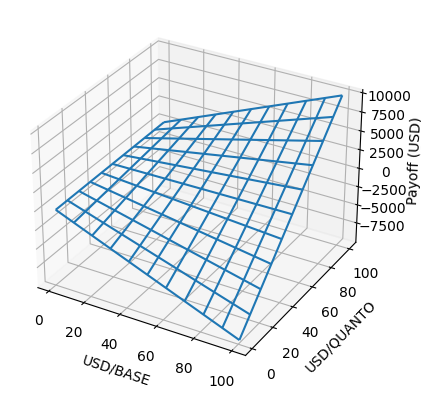

In [762]:
# Assuming Δbase and Δquanto are 1D numpy arrays
Δbase_2D, Δquanto_2D = np.meshgrid(Δbase, Δquanto)

# Initialize an empty array for payoff values
payoff_matrix = np.zeros_like(Δbase_2D)

# Calculate payoff for each combination
for i in range(Δbase_2D.shape[0]):
    for j in range(Δbase_2D.shape[1]):
        position_size = calculate_position_size(m_e, λ_e, b_e)
        notional_value = calculate_notional_value(position_size, Δbase_2D[i, j])
        initial_notional_value = calculate_initial_notional_value(m_e, λ_e)
        payoff = (
            calculate_profit_and_loss(notional_value, initial_notional_value)
            * Δquanto_2D[i, j]
        )
        payoff_matrix[i, j] = payoff

# Plotting
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_wireframe(Δquanto_2D, Δbase_2D, payoff_matrix, rstride=10, cstride=10)

# Label the axes
ax.set_xlabel("USD/BASE")
ax.set_ylabel("USD/QUANTO")
ax.set_zlabel("Payoff (USD)")

plt.show()

### Basic Liquidation Analysis (⏳ WIP)


Entry Margin

-   Units: `$QUANTO`


In [763]:
m_e = 100

Margin Exchange Rate (Set at Entry)

-   Units: `$USD/$QUANTO`

In [ ]:
exchange_rate = 50

Entry Leverage

-   Units: N/A


In [764]:
λ_e = 1

Entry Spot Price of Base Asset

-   Units: `$USD/$ASSET`


In [765]:
b_e = 50

Change in Spot Price of Base Asset (since entry)

-   Units: `$USD/$ASSET`


In [766]:
Δb = np.linspace(1, 100, 100)

Change in Spot Price of Quanto Asset (since entry)

-   Units: `$USD/$QUANTO`


In [ ]:
Δquanto = np.linspace(1, 100, 100)

Liquidation Fee Ratio

-   Units: Basis Points (BPS)


In [767]:
r_fee = 35 / 10000

Minimal Keeper Incentive

-   Units: `$USD`


In [768]:
D = 20

Liquidation Buffer Ratio

-   Units: Basis Points (BPS)


In [769]:
r_buffer = 1 / 10000

Liquidation Margin (amount of margin below which the position can be liquidated)

-   Units: `$QUANTO`


In [770]:
liq_margin = calculate_liquidation_margin(
    calculate_position_size(
        m_e,
        λ_e,
        b_e,
    ),
    Δb,
    r_fee,
    D,
    r_buffer,
)

Linear Plot of Liquidation Margin (as a function of spot price)


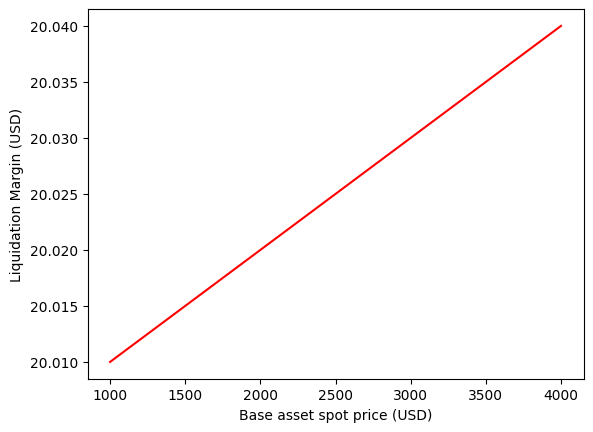

In [771]:
plt.plot(Δb, liq_margin, "r")
plt.ylabel("Liquidation Margin (USD)")
plt.xlabel("Base asset spot price (USD)")
plt.show()

Liquidation Price

-   Units: `$ASSET/$USD`


In [772]:
liq_price = calculate_approximate_liquidation_price(
    b_e,
    m_e,
    liq_margin,
    calculate_position_size(
        m_e,
        λ_e,
        b_e,
    ),
    0,  # assume unrecorded cumulative funding is nil
    0,  # assume unrecorded cumulative funding at last index is nil
)

Linear Plot of Liquidation Price (as a function of spot price)


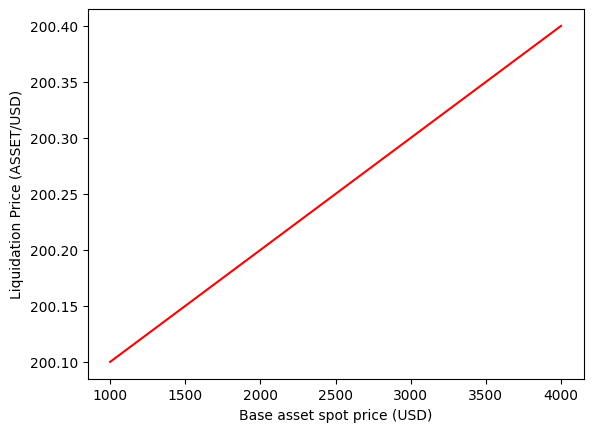

In [773]:
plt.plot(Δb, liq_price, "r")
plt.ylabel("Liquidation Price (ASSET/USD)")
plt.xlabel("Base asset spot price (USD)")
plt.show()

#### Liquidation Events given Standard Linear Payoff


Change in Spot Price of Base Asset (since entry)

-   Units: `$ASSET/$USD`


In [774]:
Δb = np.linspace(4000, 0, 100)

Payoff (as a function of spot price)

-   Units: `$USD`
-   Takes liquidation into consideration


In [775]:
liq_margin = calculate_liquidation_margin(
    calculate_position_size(
        m_e,
        λ_e,
        b_e,
    ),
    Δb,
    r_fee,
    D,
    r_buffer,
)

liq_price = calculate_approximate_liquidation_price(
    b_e,
    m_e,
    liq_margin,
    calculate_position_size(
        m_e,
        λ_e,
        b_e,
    ),
    0,  # assume unrecorded cumulative funding is nil
    0,  # assume unrecorded cumulative funding at last index is nil
)

payoff = calculate_profit_and_loss(
    calculate_notional_value(
        calculate_position_size(
            m_e,
            λ_e,
            b_e,
        ),
        Δb,
    ),
    calculate_initial_notional_value(m_e, λ_e),
)


liq_condition = Δb <= liq_price
payoff = np.where(liq_condition, -m_e, payoff)

Non-Linear Plot of Payoff (as a function of spot price)


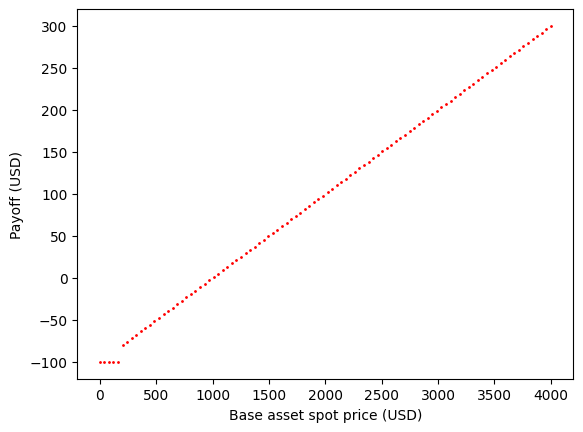

In [776]:
plt.plot(Δb, payoff, "r.", markersize=2)
plt.ylabel("Payoff (USD)")
plt.xlabel("Base asset spot price (USD)")
plt.show()